# Install & Import

In [1]:
!pip install -q segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 1.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00:00:01m0:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.8 MB/s eta 0:00:00:00:0100:01


In [2]:
import numpy as np
import pandas as pd

import os
import random

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

import seaborn as sns

from glob import glob

from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.model_selection import StratifiedGroupKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

import albumentations as A

import segmentation_models_pytorch as smp

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
print(f"Number of available CPUs: {os.cpu_count()}")
print(f"Number of available GPUs: {torch.cuda.device_count()}")

Number of available CPUs: 4
Number of available GPUs: 0


# Global variables

In [4]:
DIR_PATH = "/kaggle/input/uw-madison-gi-tract-image-segmentation/"

pd.set_option('display.max_colwidth', 400) 

CMAP1 = ListedColormap([[0, 0, 0, 0], [1, 0, 0, 1]])  # black transparent, red opaque
CMAP2 = ListedColormap([[0, 0, 0, 0], [0, 1, 0, 1]])  # black transparent, green opaque
CMAP3 = ListedColormap([[0, 0, 0, 0], [0, 0, 1, 1]])  # black transparent, blue opaque

RANDOM_SEED = 0

IMAGE_NORMALIZE_MEAN = (0.485, 0.456, 0.406)
IMAGE_NORMALIZE_SD = (0.229, 0.224, 0.225)

IMAGE_RESIZE = [288, 288]

BATCH_SIZE_TRAIN = 32
BATCH_SIZE_VALID = BATCH_SIZE_TRAIN*2

DATA_LOADER_NUM_WORKERS = 4

NUM_CLASSES = 3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 5

In [5]:
# ensure reproducibility(to some extent) across different runs
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Data Preprocessing & EDA

In [6]:
data = pd.read_csv(DIR_PATH + "train.csv")
data.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [7]:
data_nonnaseg = data.loc[data.segmentation.notna(), :]
data_nonnaseg.head()

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28886 15 29151 17 29417 17 29682 18 29948 18 30214 18 30480 18 30746 18 31012 18 31278 18 31544 18 31811 17 32077 17 32344 15 32610 15 32877 13 33144 11 33411 8
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 16649 12 16915 12 17181 12 17447 12 17713 12 17979 12 18245 12 18511 12 18777 12 19043 12 19309 12 19575 12 19841 12 20107 12 20373 12 20639 12 20905 12 21171 12 21437 12 21703 12 21969 12 22235 12 22501 12 22767 12 23033 12 23299 12 23565 12 23831 12 24097 12 24363 12 24629 12 24895 12 25161 13 25427 13 25693 14 25959 14 26224 15 26489 16 26755 17 27...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 16118 13 16383 15 16649 15 16915 15 17180 16 17446 16 17712 16 17978 16 18244 16 18510 16 18776 16 19042 16 19308 16 19574 16 19840 16 20106 16 20372 16 20638 16 20904 16 21170 16 21436 16 21702 16 21968 16 22234 16 22500 16 22766 16 23032 16 23298 17 23564 17 23830 17 24096 17 24362 17 24628 17 24894 17 25159 18 25425 18 25691 19 25956 20 26221 21 26...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15850 18 16115 19 16381 19 16646 20 16912 20 17178 20 17444 20 17710 20 17976 20 18242 20 18508 20 18774 20 19040 20 19306 20 19572 20 19838 20 20104 20 20370 20 20636 20 20902 20 21168 20 21434 20 21700 20 21966 20 22232 20 22499 19 22765 19 23030 20 23296 20 23562 20 23827 21 24093 21 24359 22 24625 22 24891 22 25156 23 25422 24 25688 24 25954 24 2...


In [8]:
data[['case', 'day', 'slice']] = data['id'].str.extract(r'case(\d+)_day(\d+)_slice_(\d+)')
data

,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001
2,case123_day20_slice_0001,stomach,NaN,123,20,0001
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002
...,...,...,...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN,30,0,0143
115484,case30_day0_slice_0143,stomach,NaN,30,0,0143
115485,case30_day0_slice_0144,large_bowel,NaN,30,0,0144
115486,case30_day0_slice_0144,small_bowel,NaN,30,0,0144


In [9]:
paths = glob(DIR_PATH + 'train/*/*/*/*')
path_df = pd.DataFrame(paths, columns=['image_path'])

# The image file corresponding to case123_day20_slice_0065 is train/case123/case123_day20/scans/slice_0065_266_266_1.50_1.50.png 
# 266, 266 are slice width, slice height and 1.5, 1.5 are pixel width, pixel height.

path_df[['case', 'day', 'slice', 
         'slice_w', 'slice_h', 
         'px_w', 'px_h']] = \
        path_df.image_path.str.extract(r'.*/case(\d+)_day(\d+)/scans/slice_(\d+)_(\d+)_(\d+)_(\d+\.\d+)_(\d+\.\d+)\.png')
path_df

,image_path,case,day,slice,slice_w,slice_h,px_w,px_h
0,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0006_266_266_1.50_1.50.png,36,14,0006,266,266,1.50,1.50
1,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0082_266_266_1.50_1.50.png,36,14,0082,266,266,1.50,1.50
2,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0113_266_266_1.50_1.50.png,36,14,0113,266,266,1.50,1.50
3,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0076_266_266_1.50_1.50.png,36,14,0076,266,266,1.50,1.50
4,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0125_266_266_1.50_1.50.png,36,14,0125,266,266,1.50,1.50
...,...,...,...,...,...,...,...,...
38491,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case33/case33_day21/scans/slice_0045_266_266_1.50_1.50.png,33,21,0045,266,266,1.50,1.50
38492,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case33/case33_day21/scans/slice_0027_266_266_1.50_1.50.png,33,21,0027,266,266,1.50,1.50
38493,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case33/case33_day21/scans/slice_0089_266_266_1.50_1.50.png,33,21,0089,266,266,1.50,1.50
38494,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case33/case33_day21/scans/slice_0123_266_266_1.50_1.50.png,33,21,0123,266,266,1.50,1.50


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
 3   case          115488 non-null  object
 4   day           115488 non-null  object
 5   slice         115488 non-null  object
dtypes: object(6)
memory usage: 5.3+ MB


In [11]:
path_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38496 entries, 0 to 38495
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  38496 non-null  object
 1   case        38496 non-null  object
 2   day         38496 non-null  object
 3   slice       38496 non-null  object
 4   slice_w     38496 non-null  object
 5   slice_h     38496 non-null  object
 6   px_w        38496 non-null  object
 7   px_h        38496 non-null  object
dtypes: object(8)
memory usage: 2.3+ MB


We see that the number of rows in data df is 3x that of path_df. 
Each (case, day, slice) entry in path_df has 3 matching entries in data, corresponding to the 3 segmentation classes

In [12]:
data = data.merge(path_df, on = ['case', 'day', 'slice'])
data

,id,class,segmentation,case,day,slice,image_path,slice_w,slice_h,px_w,px_h
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266,1.50,1.50
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266,1.50,1.50
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266,1.50,1.50
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png,266,266,1.50,1.50
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png,266,266,1.50,1.50
...,...,...,...,...,...,...,...,...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN,30,0,0143,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png,266,266,1.50,1.50
115484,case30_day0_slice_0143,stomach,NaN,30,0,0143,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png,266,266,1.50,1.50
115485,case30_day0_slice_0144,large_bowel,NaN,30,0,0144,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png,266,266,1.50,1.50
115486,case30_day0_slice_0144,small_bowel,NaN,30,0,0144,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png,266,266,1.50,1.50


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
 3   case          115488 non-null  object
 4   day           115488 non-null  object
 5   slice         115488 non-null  object
 6   image_path    115488 non-null  object
 7   slice_w       115488 non-null  object
 8   slice_h       115488 non-null  object
 9   px_w          115488 non-null  object
 10  px_h          115488 non-null  object
dtypes: object(11)
memory usage: 9.7+ MB


In [14]:
data.px_w.unique(), data.px_h.unique()

(array(['1.50', '1.63'], dtype=object), array(['1.50', '1.63'], dtype=object))

In [15]:
data.case.unique(), data.day.unique(), data.slice.unique(), data.slice_w.unique(), data.slice_h.unique()

(array(['123', '77', '133', '129', '139', '130', '88', '44', '145', '15',
        '110', '42', '118', '66', '91', '142', '58', '63', '114', '102',
        '115', '65', '53', '122', '125', '117', '140', '134', '9', '113',
        '90', '49', '19', '6', '67', '154', '135', '84', '147', '101', '7',
        '119', '32', '24', '33', '22', '149', '11', '148', '124', '111',
        '89', '136', '116', '143', '35', '108', '43', '55', '141', '92',
        '16', '131', '81', '34', '36', '20', '121', '29', '18', '138',
        '146', '144', '40', '54', '78', '47', '156', '85', '107', '41',
        '80', '2', '74', '30'], dtype=object),
 array(['20', '22', '0', '18', '25', '23', '24', '27', '16', '14', '38',
        '36', '19', '12', '17', '34', '26', '15', '28', '13', '10', '21',
        '29', '32', '30', '6', '8', '11', '35', '39', '1', '5', '2', '3',
        '4'], dtype=object),
 array(['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008',
        '0009', '0010', '0011', '0012', '0013

In [16]:
int_cols = ['case', 'day', 'slice', 'slice_w', 'slice_h']
data[int_cols] = data[int_cols].astype(np.uint32)

float_cols = ['px_w', 'px_h']
data[float_cols] = data[float_cols].astype(np.float32)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            115488 non-null  object 
 1   class         115488 non-null  object 
 2   segmentation  33913 non-null   object 
 3   case          115488 non-null  uint32 
 4   day           115488 non-null  uint32 
 5   slice         115488 non-null  uint32 
 6   image_path    115488 non-null  object 
 7   slice_w       115488 non-null  uint32 
 8   slice_h       115488 non-null  uint32 
 9   px_w          115488 non-null  float32
 10  px_h          115488 non-null  float32
dtypes: float32(2), object(4), uint32(5)
memory usage: 6.6+ MB


## Run Length Encoding (RLE)

In [17]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## get_mask

In [18]:
def get_mask(id_, data):
    data_subset_id = data.loc[data['id']==id_]
    slice_dim = data_subset_id[['slice_h', 'slice_w']].iloc[0]
    shape = (slice_dim.slice_h, slice_dim.slice_w, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        data_subset_class = data_subset_id[data_subset_id['class']==class_]
        rle = data_subset_class.segmentation.squeeze()
        if not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

In [ ]:
full_image_file_path = DIR_PATH + "train/case123/case123_day20/scans/slice_0065_266_266_1.50_1.50.png"

img = cv2.imread(full_image_file_path, cv2.IMREAD_UNCHANGED)
# default imread mode is IMREAD_COLOR which expects 8-bit 3 channel image, our input image is 16-bit grayscale which requires IMREAD_UNCHANGED

print(img.shape)
print(img)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Gray')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img, cmap='bone')
plt.title('Bone')
plt.axis('off')
plt.colorbar()

# while gray cmap is technically most correct for 16-bit grayscale image, using bone cmap from now on to enhance contrast visually

plt.tight_layout()
plt.show()

(266, 266)
[[ 0  0 19 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


[[0.         0.         0.00141243 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(266, 266)
1.0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(266, 266)
255
[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
(266, 266)
255
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
(266, 266)
255


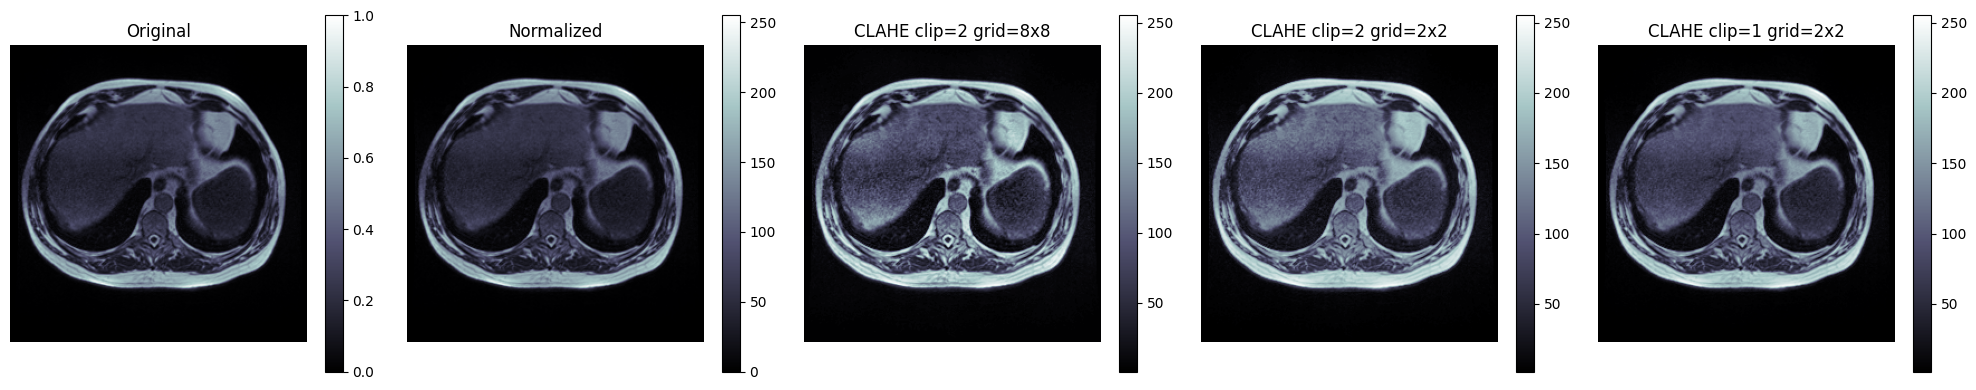

In [20]:
img = cv2.imread(full_image_file_path, cv2.IMREAD_UNCHANGED).astype('float32')

img_norm = img
mx = np.max(img)
if mx > 0:
    img_norm /= mx

print(img_norm)
print(img_norm.shape)
print(max([max(r) for r in img_norm]))

img_norm = (img_norm*255).astype(np.uint8)
print(img_norm)
print(img_norm.shape)
print(max([max(r) for r in img_norm]))

clahe1 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe2 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
clahe3 = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))

res1 = clahe1.apply(img_norm)
res2 = clahe2.apply(img_norm)
res3 = clahe3.apply(img_norm)

print(res1)
print(res1.shape)
print(max([max(r) for r in res1]))

print(res2)
print(res2.shape)
print(max([max(r) for r in res2]))

# Show results
plt.figure(figsize=(20, 4))
for i, (title, im) in enumerate(zip(['Original', 'Normalized', 'CLAHE clip=2 grid=8x8', 'CLAHE clip=2 grid=2x2', 'CLAHE clip=1 grid=2x2'], [img, img_norm, res1, res2, res3])):
    plt.subplot(1,5,i+1)
    plt.imshow(im, cmap='bone')
    plt.title(title)
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.show()

Based on the above figures, decided to use CLAHE clip=1 grid=2x2 for best visualization

## display_image

In [21]:
def load_image(id_, data):
    data_subset = data.loc[data.id == id_]
    img = cv2.imread(data_subset.image_path.iloc[0], cv2.IMREAD_UNCHANGED).astype('float32')  # convert from original 16-bit
    #print(f'Raw image {id_} min : {np.min(img)} max : {np.max(img)}')
    mx = np.max(img)
    if mx > 0:
        img /= mx
    return img

In [22]:
def display_image(id_, data, pred_mask=None, apply_CLAHE=False,
                  show_orig_img=True, show_true_mask=True, show_pred_mask=False):
    
    img = load_image(id_, data)
    #print(f'load_image result {id_} min : {np.min(img)} max : {np.max(img)}')
    img = (img * 255).astype(np.uint8) # 0-255 range required for CLAHE. 
                                       # Using this in general to maintain consistency with the case where CLAHE is required
    #print(f'just before CLAHE {id_} min : {np.min(img)} max : {np.max(img)}')
    if apply_CLAHE:
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
        img = clahe.apply(img)
    
    mask = get_mask(id_, data)

    plt.figure(figsize=(9, 3))
    
    i = 1
    if show_orig_img:
        plt.subplot(1, 3, i)
        i += 1
        #print(f'just before imshow {id_} min : {np.min(img)} max : {np.max(img)}')
        plt.imshow(img, cmap='bone')
        plt.title(f'{id_} image')
        plt.axis('off')

    if show_true_mask:
        plt.subplot(1, 3, i)
        i += 1
        print(f'just before imshow {id_} min : {np.min(img)} max : {np.max(img)}')
        print(img.shape)
        plt.imshow(img, cmap='bone')
        plt.title('Image with true mask')
        plt.imshow(mask[..., 0], cmap=CMAP1)
        plt.imshow(mask[..., 1], cmap=CMAP2)
        plt.imshow(mask[..., 2], cmap=CMAP3)
        
        handles = [
            Rectangle((0, 0), 1, 1, color=CMAP1(1.0)),
            Rectangle((0, 0), 1, 1, color=CMAP2(1.0)),
            Rectangle((0, 0), 1, 1, color=CMAP3(1.0))
        ]
        labels = ['Large Bowel', 'Small Bowel', 'Stomach']
        plt.axis('off')
        plt.legend(handles, labels, bbox_to_anchor=(1.0, -0.4), loc='lower right', borderaxespad=0.)
    
    if show_pred_mask and pred_mask is not None:
        plt.subplot(1, 3, i)
        plt.imshow(img, cmap='bone')
        plt.title('Image with predicted mask')
        plt.imshow(pred_mask[..., 0], cmap=CMAP1)
        plt.imshow(pred_mask[..., 1], cmap=CMAP2)
        plt.imshow(pred_mask[..., 2], cmap=CMAP3)
        
        handles = [
            Rectangle((0, 0), 1, 1, color=CMAP1(1.0)),
            Rectangle((0, 0), 1, 1, color=CMAP2(1.0)),
            Rectangle((0, 0), 1, 1, color=CMAP3(1.0))
        ]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.axis('off')
        plt.legend(handles, labels, bbox_to_anchor=(1.0, -0.4), loc='lower right', borderaxespad=0.)
    
    
    plt.tight_layout()
    plt.show()  

just before imshow case131_day0_slice_0066 min : 0 max : 255
(310, 360)


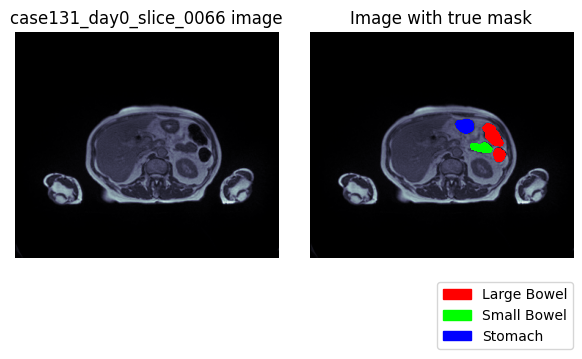

In [23]:
display_image('case131_day0_slice_0066', data)

just before imshow case131_day0_slice_0066 min : 2 max : 255
(310, 360)


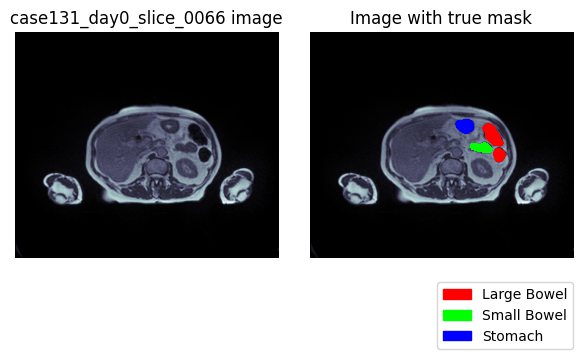

In [24]:
display_image('case131_day0_slice_0066', data, apply_CLAHE=True)

In [25]:
# # testing pred_mask display using true mask
# display_image('case131_day0_slice_0066', data, pred_mask=get_mask('case131_day0_slice_0066', data),
#               show_pred_mask=True, apply_CLAHE=True)

just before imshow case123_day20_slice_0065 min : 2 max : 255
(266, 266)


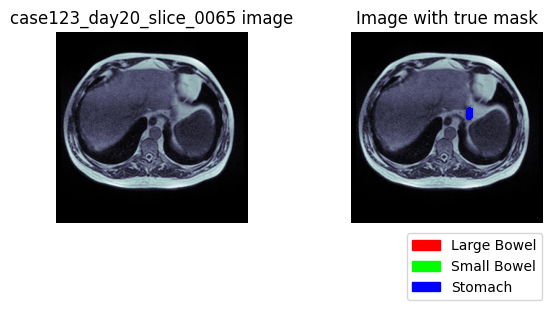

In [26]:
# example image with only stomach segment
display_image('case123_day20_slice_0065', data, apply_CLAHE=True)

just before imshow case123_day20_slice_0001 min : 2 max : 255
(266, 266)


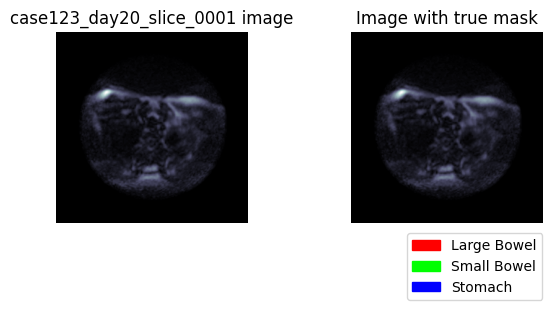

In [27]:
# example image without any segment
display_image('case123_day20_slice_0001', data, apply_CLAHE=True)

We see that the max value in the raw image for the 3 images shown previously are significantly different : 605, 13452, 2546

## display_multiple_slices

In [28]:
def display_multiple_slices(id_array, data, apply_CLAHE=False,
                            show_pred_mask=False, pred_mask_array=None):

    '''
    id_array : an array of ids like case123_day20_slice_0001
    data     : dataframe containing all the image metadata 
    apply_CLAHE : whether or not to apply CLAHE
    show_pred_mask : if this parameter is False, then true mask will be shown
                     if it is True, masks from pred_mask_array will be shown
    pred_mask_array : array of prediction masks
    '''

    l = len(id_array)
    rows = np.ceil(l/5).astype(int)
    max_cols = 5
    data_subset = data.loc[data.id.isin(id_array), ]

    plt.figure(figsize=(max_cols*3, rows*3))

    for i in range(l):
        
        img = cv2.imread(data_subset.image_path.iloc[3*i], cv2.IMREAD_UNCHANGED).astype('float32')  # 3*i because every 3 image paths are same 
                                                                                                    #     and we read 1st entry only
        mx = np.max(img)
        if mx > 0:
            img /= mx

        if apply_CLAHE:
            clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
            img = (img * 255).astype(np.uint8)
            img = clahe3.apply(img)

        id_ = data_subset.id.iloc[3*i]

        if show_pred_mask and pred_mask_array is not None:
            mask = pred_mask_array[3*i]
        else:
            mask = get_mask(id_, data)

        plt.subplot(rows, max_cols, i+1)
        plt.imshow(img, cmap='bone')
        plt.title(id_)
        plt.imshow(mask[..., 0], cmap=CMAP1)
        plt.imshow(mask[..., 1], cmap=CMAP2)
        plt.imshow(mask[..., 2], cmap=CMAP3)
        plt.axis('off')

        if i == 0:
            handles = [
                Rectangle((0, 0), 1, 1, color=CMAP1(1.0)),
                Rectangle((0, 0), 1, 1, color=CMAP2(1.0)),
                Rectangle((0, 0), 1, 1, color=CMAP3(1.0))
            ]
            labels = ['Large Bowel', 'Small Bowel', 'Stomach']
        
            plt.legend(handles, labels, bbox_to_anchor=(0.0, 1.5), loc='upper left', borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()  

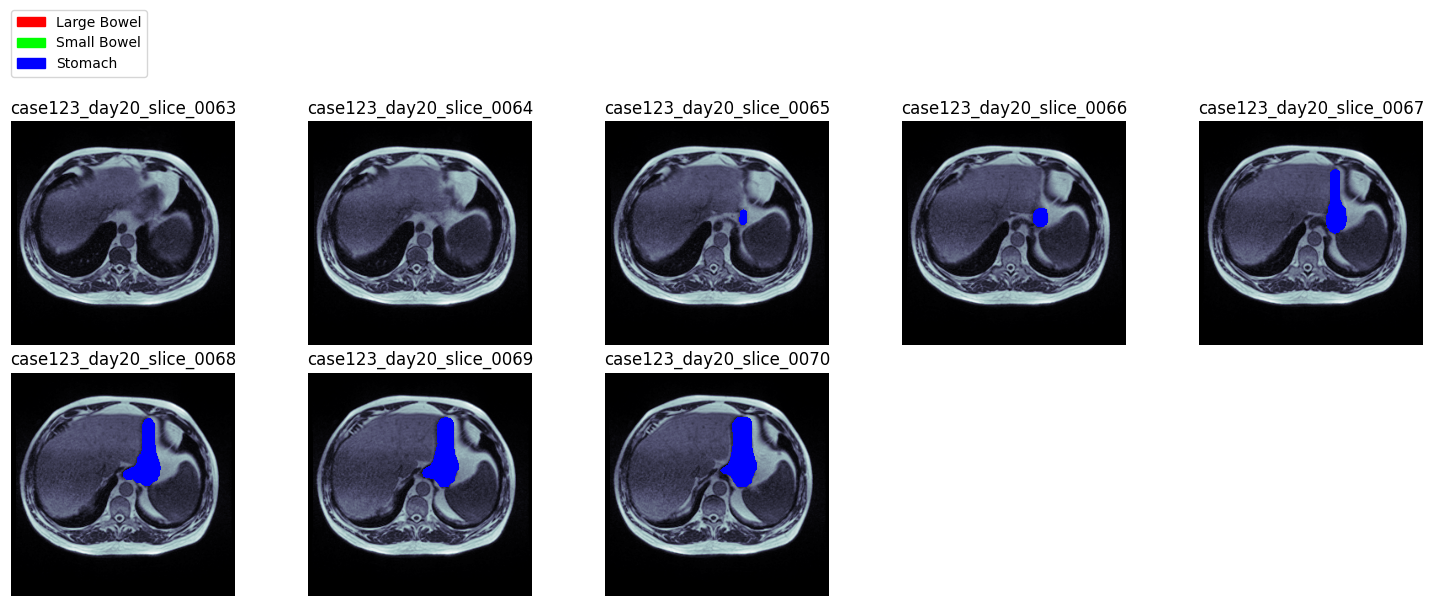

In [29]:
# using the below data to visualize change in segmentation mask across different slices
# data.query("case == 123 and day == 20 and slice >= 63 and slice <= 70")
display_multiple_slices(data.query("case == 123 and day == 20 and slice >= 63 and slice <= 70").id.unique(), 
                        data, apply_CLAHE=True)

In [ ]:
# using the below data to visualize change in segmentation mask across different slices - for a case where all masks are present
# data.query("case == 131 and day == 0 and slice > 60 and slice <= 70")
display_multiple_slices(data.query("case == 131 and day == 0 and slice > 55 and slice <= 70").id.unique(), 
                        data, apply_CLAHE=True)

## EDA

In [ ]:
data.loc[data.segmentation.isna(), :]

In [ ]:
# How many missing values
data.isna().sum()

Only segmentation column contains NaN / missing values

In [ ]:
print(f'Num cases : {len(data.case.unique())} \
        Num unique days : {len(data.day.unique())}   \
        Num unique slices : {len(data.slice.unique())}')

In [ ]:
# proportion of different slice sizes
count_df = data[['id', 'slice_w', 'slice_h']].drop_duplicates()[['slice_w', 'slice_h']].value_counts().reset_index(name='count')
count_df['percent'] = count_df['count']*100 / sum(count_df['count'])
print(sum(count_df['count']))
count_df

In [ ]:
# proportion of different pixel sizes
count_df = data[['id', 'px_w', 'px_h']].drop_duplicates()[['px_w', 'px_h']].value_counts().reset_index(name='count')
count_df['percent'] = count_df['count']*100 / sum(count_df['count'])
print(sum(count_df['count']))
count_df

In both of the 2 cells above, after dropping duplicates, there will be only single entry corresponding to a specific image path.
Hence the sum of counts is equal to the path_df length (or 1/3 of data length).

We see that all the slices (except 360x310) and pixels are squares (same width and height).
266x266 is the most frequent slice size - 67%, followed by 360x310 - 29%. 

We could resize to 256x256 or 288x288 image size for training the model (UNet model expects input sizes in multiples of 32), and monitor the performance in 360x310 sliced images to verify if slightly larger size combined with different width-height causes issues

In [ ]:
day_dist = data[['case', 'day']].drop_duplicates()['case'].value_counts().reset_index(name='num_days')

display(day_dist)

sns.histplot(data=day_dist, x='num_days', bins=range(1, day_dist['num_days'].max() + 1), discrete=True)
plt.xlabel('Number of Days per Case')
plt.ylabel('Number of Cases')
plt.title('Distribution of Days per Case')
plt.show()

85 unique cases with most cases having 3 days data

In [ ]:
slice_dist = data[['case', 'day', 'slice']].drop_duplicates()[['case', 'day']].value_counts().reset_index(name='num_slices')
display(slice_dist)

sns.histplot(data=slice_dist, x='num_slices', bins=range(1, slice_dist['num_slices'].max() + 1), discrete=True)
plt.xlabel('Number of slices per case-days')
plt.ylabel('Number of specific case-days')
plt.title('Distribution of slices per case-day')
plt.show()

display(slice_dist.num_slices.value_counts())

274 unique case-days having mostly 144 slices and few of them with 80 slices

In [ ]:
slice_dist.loc[slice_dist.num_slices == 80, :]

In [ ]:
case_day_slice_df = data[['case', 'day', 'slice', 'slice_w', 'slice_h']].drop_duplicates()
case_day_slice_df.merge(case_day_slice_df, on=['case', 'day']).query("(slice_w_x != slice_w_y) | (slice_h_x != slice_h_y)")

All slices within a specific case-day have the same slice_w and slice_h

In [ ]:
case_day_slice_df = data[['case', 'day', 'slice', 'slice_w', 'slice_h']].drop_duplicates()
case_day_slice_df.merge(case_day_slice_df, on=['case']).query("(slice_w_x != slice_w_y) | (slice_h_x != slice_h_y)")

But within a specific case multiple days can have different slice_w and slice_h

In [ ]:
case_day_slice_df = data[['case', 'day', 'slice', 'px_w', 'px_h']].drop_duplicates()
case_day_slice_df.merge(case_day_slice_df, on=['case', 'day']).query("(px_w_x != px_w_y) | (px_h_x != px_h_y)")

In [ ]:
case_day_slice_df = data[['case', 'day', 'slice', 'px_w', 'px_h']].drop_duplicates()
case_day_slice_df.merge(case_day_slice_df, on=['case']).query("(px_w_x != px_w_y) | (px_h_x != px_h_y)")

Same for pixel sizes. All slices within specific case-day have same pixel size, but different days within same case can have different pixel size.

## EDA - missing masks

In [ ]:
num_missing_seg_masks = data.segmentation.isna().sum() 
print(f'Missing Seg Mask \n count = {num_missing_seg_masks}\n percentage = {num_missing_seg_masks/len(data)*100}')

Approximately 70% of entries have missing segmentation masks

In [ ]:
data['class'].value_counts()

As expected (previously seen that number of rows in data df is 3x that of path_df), all 3 segmentation classes have equal number of entries.

In [ ]:
na_counts = (
    data.groupby('class')['segmentation']
    .apply(lambda s: s.isna().sum())
    .reset_index(name='count')
)
na_counts['percent'] = 100 * na_counts['count'] / data.groupby('class')['segmentation'].size().values

display(na_counts)

sns.set_style("whitegrid") 
ax = sns.barplot(data=na_counts, x='class', y='percent', palette=[CMAP1(1.0), CMAP2(1.0), CMAP3(1.0)])

for i, row in na_counts.iterrows():
    ax.text(i, row['percent'] + 1,  # position just above the bar
            f"{row['percent']:.2f}% ({row['count']})",
            ha='center', va='bottom', fontsize=10)

plt.ylabel('Percentage')
plt.xlabel('Segmentation Class')
plt.title('Missing Segmentation Masks')
plt.yticks(range(0, 105, 10))
plt.show()

In [ ]:
case_day_seg_missing = (
     data[['case', 'day', 'class', 'segmentation']]
     .groupby(['case', 'day', 'class'])['segmentation']
     .apply(lambda s: s.isna().sum())
     .reset_index(name='count').sort_values(by='count', ascending=False)
)
display(case_day_seg_missing)


# sns.set_style("whitegrid") 
# ax = sns.barplot(data=na_counts, x='class', y='percent', palette=[CMAP1(1.0), CMAP2(1.0), CMAP3(1.0)])

# for i, row in na_counts.iterrows():
#     ax.text(i, row['percent'] + 1,  # position just above the bar
#             f"{row['percent']:.2f}% ({row['count']})",
#             ha='center', va='bottom', fontsize=10)

# plt.ylabel('Percentage')
# plt.xlabel('Segmentation Class')
# plt.title('Missing Segmentation Masks')
# plt.yticks(range(0, 105, 10))
# plt.show()

sns.boxplot(data=case_day_seg_missing, x='class', y='count', palette=[CMAP1(1.0), CMAP2(1.0), CMAP3(1.0)])
sns.stripplot(data=case_day_seg_missing, x='class', y='count', color='black', size=3, jitter=True, alpha=0.4)
plt.ylabel('Missing Mask Count')
plt.xlabel('Segmentation Class')
plt.title('Distribution of Missing Masks per Class (by Case-Day)')
plt.show()

Only 1 case-day seems to have all 144 slices missing large_bowel (case 43 - day 26). Lets visualize those slices.

In [ ]:
# display_multiple_slices(data.query("case == 43 and day == 26").id.unique(), 
#                         data, apply_CLAHE=True)

In [ ]:
#visualizing the original image and image with true mask for border slices where segmentation classes just start appearing/disapperaing
display_image('case43_day26_slice_0057', data, apply_CLAHE=True)
display_image('case43_day26_slice_0058', data, apply_CLAHE=True)
display_image('case43_day26_slice_0121', data, apply_CLAHE=True)
display_image('case43_day26_slice_0122', data, apply_CLAHE=True)

day 15 for case 117 has the least number of missing. Lets visualize that too

In [ ]:
# display_multiple_slices(data.query("case == 117 and day == 15").id.unique(), 
#                         data, apply_CLAHE=True)

In [ ]:
#visualizing the original image and image with true mask for border slices where segmentation classes just start appearing/disapperaing
display_image('case117_day15_slice_0009', data, apply_CLAHE=True)
display_image('case117_day15_slice_0010', data, apply_CLAHE=True)
display_image('case117_day15_slice_0065', data, apply_CLAHE=True)
display_image('case117_day15_slice_0066', data, apply_CLAHE=True)

The general structure of all slices per day seem to be that only the middle slices have the segmentation classes visible.

# Train validation split

The competition data description mentions that there are some cases with early days in train and later days in test, and some other cases where entirety of case is in train or test.

We could split cases into 2 - set1, set2 where set1 could be used for partially unseen cases and set2 for wholly unseen cases.
set1 could be created as  : for each case 80% of early days in train, and 20% later days in test
set2 could be created as  : 80% of cases in train and 20% in test

Also, in both these approaches it would be good to incorporate empty segmentation mask percentage.

But the number of days in different cases is different, and as we have seen previously, there are large number of cases with 1 or 2 or 3 days. This would make set1 based approach more complicated. So for now, we'll rely on only set2 based approach.

In [ ]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
index_train, index_valid = next(sgkf.split(data.id, data.segmentation.isna(), data.case))

In [ ]:
len(index_train), len(index_valid)

In [ ]:
data_train = data.iloc[index_train, :]
data_valid = data.iloc[index_valid, :]

In [ ]:
data_train

In [ ]:
data_valid

## Using data subset
To start off with, we'll use a smaller dataset by considering around 1/10 th of the cases

In [ ]:
print(len(data_train.case.unique()), len(data_valid.case.unique()))

In [ ]:
data_train_sub = data_train.loc[data_train.case.isin(data_train.case.unique()[:11]), :]
data_valid_sub = data_valid.loc[data_valid.case.isin(data_valid.case.unique()[:2]), :]

print(len(data_train_sub), len(data_valid_sub), len(data_train_sub)/len(data_valid_sub))

# Note : 11, 2 numbers obtained by manually trying numbers 
#              with 18/10 ~ 2 for valid and such that train len/valid len ~ 4 similar to 4 splits for train and 1 split for valid

In [ ]:
missing_masks_train = data_train_sub.segmentation.isna().sum() 
missing_masks_valid = data_valid_sub.segmentation.isna().sum() 
print(missing_masks_train, missing_masks_train*100/len(data_train_sub))
print(missing_masks_valid, missing_masks_valid*100/len(data_valid_sub))

approximately similar

In [ ]:
na_counts_train = (
    data_train_sub.groupby('class')['segmentation']
    .apply(lambda s: s.isna().sum())
    .reset_index(name='count')
)
na_counts_train['percent'] = 100 * na_counts_train['count'] / data_train_sub.groupby('class')['segmentation'].size().values

display(na_counts_train)


na_counts_valid = (
    data_valid_sub.groupby('class')['segmentation']
    .apply(lambda s: s.isna().sum())
    .reset_index(name='count')
)
na_counts_valid['percent'] = 100 * na_counts_valid['count'] / data_valid_sub.groupby('class')['segmentation'].size().values

display(na_counts_valid)

roughly same with some difference in large_bowel missing percentage

In [ ]:
data_train_sub = data_train_sub.reset_index(drop=True)

In [ ]:
data_valid_sub = data_valid_sub.reset_index(drop=True)

# Dataset

In [ ]:
# intensity ranges of images are inconsistent as seen in this cell's output shown commented
# so it is better to use per image scaling while loading images instead of globally normalizing by 65535(since image is 16 bit)

# def read_image(id_, data):
#   data_subset = data.loc[data.id == id_]
#   img = cv2.imread(data_subset.image_path.iloc[0], cv2.IMREAD_UNCHANGED)
#   return img

# sample_image = read_image('case123_day0_slice_0001', data)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case123_day0_slice_0002', data)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case123_day0_slice_0003', data)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case123_day20_slice_0001', data)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case123_day22_slice_0001', data)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case42_day0_slice_0001', data)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case42_day17_slice_0001', data)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case42_day19_slice_0001', data)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case129_day0_slice_0001', data)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case129_day20_slice_0001', data)
# print(np.min(sample_image), np.max(sample_image))

# sample_image = read_image('case129_day22_slice_0001', data)
# print(np.min(sample_image), np.max(sample_image))

# # 0 3621
# # 0 3553
# # 0 2822
# # 0 2546
# # 0 6886
# # 0 2322
# # 0 1332
# # 0 4326
# # 0 521
# # 0 363
# # 0 200

In [ ]:
class GITractDataset(Dataset):
    def __init__(self, df, is_train=True, transforms=None):
        self.df = df
        self.id_ = df['id'].unique()
        self.is_train = is_train
        self.transforms = transforms

    def __len__(self):
        return len(self.id_)
    
    def __getitem__(self, idx):
        id_ = self.id_[idx]
        img = load_image(id_, self.df)
        img = np.tile(img[..., None], [1, 1, 3])
        if self.is_train:
            mask = get_mask(id_, self.df)
            if self.transforms:
                augmented = self.transforms(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
            return img, mask, id_
        else:
            if self.transforms:
                augmented = self.transforms(image=img)
                img = augmented['image']
            return img, id_

# Data Augmentation

In [ ]:
transform_train = A.Compose([
    A.Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1], interpolation=cv2.INTER_NEAREST,
             mask_interpolation=cv2.INTER_NEAREST,),
    A.Normalize(mean=IMAGE_NORMALIZE_MEAN, std=IMAGE_NORMALIZE_SD, max_pixel_value=1.0),
    A.ToTensorV2(transpose_mask = True),
])

transform_valid = A.Compose([
    A.Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1], interpolation=cv2.INTER_NEAREST,
             mask_interpolation=cv2.INTER_NEAREST,),
    A.Normalize(mean=IMAGE_NORMALIZE_MEAN, std=IMAGE_NORMALIZE_SD, max_pixel_value=1.0),
    A.ToTensorV2(transpose_mask = True),
])

In [ ]:
dataset_train = GITractDataset(data_train_sub, transforms=transform_train)
dataset_valid = GITractDataset(data_valid_sub, transforms=transform_valid)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=DATA_LOADER_NUM_WORKERS)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE_VALID, shuffle=False, num_workers=DATA_LOADER_NUM_WORKERS)

In [ ]:
dataset = next(iter(dataloader_train))
img, mask, id_ = dataset
print(img.shape, mask.shape, len(id_))

In [ ]:
idx = 31
np.max(img[idx].numpy()), np.min(img[idx].numpy())

In [ ]:
def display_dataset(dataset, display_orig=False, num_images=None, denormalize=False, apply_CLAHE=False):
	'''
	dataset : dataset to be displayed
	display_orig : Should the original images prior to augmentation be shown alongside images after augmentation.
				   In this case 1st 5 images before and after augmentation is shown and num_images parameter value is ignored
	num_images : Number of images to be shown. Defaults to the full dataset size i.e. the batch size
	denormalize : Set to True if A.normalize has been applied as part of augmentations and you wish to denormalize it
	'''
	img_arr, mask_arr, id_arr = dataset
	if num_images is None:
		num_images = len(img_arr)
	max_cols = 5
	
	if display_orig:
		num_images = 5
		rows = 2
		plt.figure(figsize=(max_cols*3, rows*3))
		ids_shown = list()
	else:
		rows = np.ceil(num_images/max_cols).astype(int)
		plt.figure(figsize=(max_cols*3, rows*3))
	
	for idx in range(num_images):
		img, mask, id_ = img_arr[idx], mask_arr[idx], id_arr[idx]
		img = img.permute((1,2,0))    #after the permute, img is in HxWxC format
		if denormalize:
			#print('denormalizing')
			#print(img.shape)
			img = img * torch.tensor(IMAGE_NORMALIZE_SD) + torch.tensor(IMAGE_NORMALIZE_MEAN)
			img = img.clamp(0, 1)
		img = img.cpu().numpy()
		img = (img * 255).astype(np.uint8)

		if apply_CLAHE:
			clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
			for ch in range(3):
				img[:,:,ch] = clahe.apply(img[:,:,ch])

		mask = mask.permute((1,2,0)).cpu().numpy()

		plt.subplot(rows, max_cols, idx+1)
		#print(f'just before imshow {id_} min : {np.min(img)} max : {np.max(img)}')
		print(img.shape)
		#print(f'just before imshow mask {id_} min : {np.min(mask)} max : {np.max(mask)}')
		plt.imshow(img[:, :, 0], cmap='bone')  #img was tiled grayscale, to display just use any 1 channel
		plt.title(f'{idx} : {id_}')
		
		plt.imshow(mask[..., 0], cmap=CMAP1)
		plt.imshow(mask[..., 1], cmap=CMAP2)
		plt.imshow(mask[..., 2], cmap=CMAP3)
		plt.axis('off')

		if idx == 0:
			handles = [
				Rectangle((0, 0), 1, 1, color=CMAP1(1.0)),
				Rectangle((0, 0), 1, 1, color=CMAP2(1.0)),
				Rectangle((0, 0), 1, 1, color=CMAP3(1.0))
			]
			labels = ['Large Bowel', 'Small Bowel', 'Stomach']
			plt.legend(handles, labels, bbox_to_anchor=(0.0, 1.5), loc='upper left', borderaxespad=0.)

		if display_orig:
			ids_shown.append(id_)

	if display_orig:
		print(ids_shown)

		for id_ in ids_shown:
			idx += 1
			img = load_image(id_, data)
			img = (img * 255).astype(np.uint8) # 0-255 range required for CLAHE. 
											   # Using this in general to maintain consistency with the case where CLAHE is required
			if apply_CLAHE:
				clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
				img = clahe.apply(img)
				
			mask = get_mask(id_, data)
			
			plt.subplot(rows, max_cols, idx+1)
			#print(f'just before imshow orig {id_} min : {np.min(img)} max : {np.max(img)}')
			print(img.shape)
			plt.imshow(img, cmap='bone')
			plt.title('Original')
			plt.imshow(mask[..., 0], cmap=CMAP1)
			plt.imshow(mask[..., 1], cmap=CMAP2)
			plt.imshow(mask[..., 2], cmap=CMAP3)
			plt.axis('off')

	plt.tight_layout()
	plt.show()

In [ ]:
display_dataset(dataset, num_images=5, denormalize=True)

In [ ]:
display_dataset(dataset, display_orig=True, denormalize=True, apply_CLAHE=True)

# Model

In [ ]:
# https://smp.readthedocs.io/en/latest/encoders_timm.html

model = smp.Unet(
    encoder_name='tu-efficientnetv2_s',        
    encoder_weights='imagenet',     
    in_channels=3,                  
    classes=NUM_CLASSES,                      
)

# Training

In [ ]:
#might be tricky to use 2 functions for train and valid when using tqdm loop - improve code later if needed

for epoch in range(EPOCHS):
    
    model.train() #set model in training mode
    running_loss = 0.0
    
    loop = tqdm(dataloader_train, desc=f'Epoch {epoch+1}/{TRAIN_EPOCHS}')
    for i, data in enumerate(loop):
        images, masks, ids = data
        optimizer.zero_grad()
        pred_masks = model(images)

        loss = loss_fn(pred_masks, masks)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(dataloader_train)
    print(f'Epoch {epoch+1} finished, Avg Loss = {avg_loss: .3f}')

# References
* https://www.kaggle.com/code/awsaf49/uwmgi-mask-data
* https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode
* https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch
* https://www.kaggle.com/code/andradaolteanu/aw-madison-eda-in-depth-mask-exploration
* https://www.kaggle.com/code/masatomurakawamm/uwmgi-pspnet-u-net-deeplabv3-swin-unet